In [ ]:
›from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-learn
import os
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def load_images_from_folder(folder_path):
    images = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            img = cv2.imread(os.path.join(folder_path, fname))
            if img is not None:
                images.append(img)
    return images

In [ ]:
def preprocess_image(img):
    # RGB normalize
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    # Grayscale & uint8
    gray = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    # Resize
    gray = cv2.resize(gray, (256, 256), interpolation=cv2.INTER_AREA)
    # Denoise
    blurred = cv2.GaussianBlur(gray, (5,5), sigmaX=0)
    # CLAHE contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(blurred)
    # Flatten & normalize feature vector
    return (enhanced.astype(np.float32).ravel() / 255.0)

Total samples: 705 (Normal=309, Glaucoma=396)
PCA reduced dimension -> 239 components
Train/Test split: 564 train, 141 test
Best SVM parameters found: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Test Accuracy:           72.34%
Sensitivity (Recall+):   81.01%
Specificity (Recall-):   61.29%
PPV (Precision+):        72.73%
NPV (Precision-):        71.70%


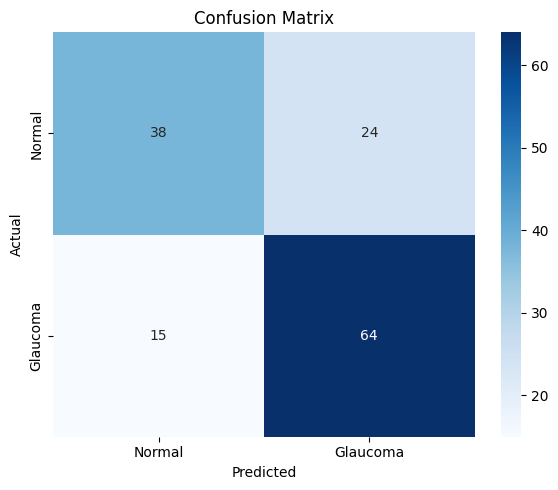

In [ ]:

    normal_imgs   = load_images_from_folder('/content/drive/MyDrive/Leetcode images/datasets/ACRIMA/normal')
    glaucoma_imgs = load_images_from_folder('/content/drive/MyDrive/Leetcode images/datasets/ACRIMA/glaucoma')

    X, y = [], []
    for img in normal_imgs:
        X.append(preprocess_image(img)); y.append(0)
    for img in glaucoma_imgs:
        X.append(preprocess_image(img)); y.append(1)

    X = np.array(X)
    y = np.array(y)
    print(f"Total samples: {len(y)} (Normal={np.sum(y==0)}, Glaucoma={np.sum(y==1)})")

    # PCA: retain 95% variance
    pca = PCA(n_components=0.95, svd_solver='auto')
    X_pca = pca.fit_transform(X)
    print(f"PCA reduced dimension -> {X_pca.shape[1]} components")

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pca)

    # Train-test split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Train/Test split: {len(y_train)} train, {len(y_test)} test")

    # Grid search on training set
    param_grid = {
        #Regularization
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'kernel': ['rbf']
    }

    #cross validation with 5 fold and use all the CPU cores
    grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best SVM parameters found:", grid.best_params_)

    # Retrain with best params on full training set
    best_svm = grid.best_estimator_
    best_svm.fit(X_train, y_train)

    # Predict on test set
    y_pred = best_svm.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    sens = recall_score(y_test, y_pred, pos_label=1)
    spec = recall_score(y_test, y_pred, pos_label=0)
    ppv  = precision_score(y_test, y_pred, pos_label=1)
    npv  = precision_score(y_test, y_pred, pos_label=0)
    cm   = confusion_matrix(y_test, y_pred)

    print(f"\nTest Accuracy:           {acc*100:.2f}%")
    print(f"Sensitivity (Recall+):   {sens*100:.2f}%")
    print(f"Specificity (Recall-):   {spec*100:.2f}%")
    print(f"PPV (Precision+):        {ppv*100:.2f}%")
    print(f"NPV (Precision-):        {npv*100:.2f}%")
    # Assuming y_test and y_pred are already defined
    cm = confusion_matrix(y_test, y_pred)

    # Optional: Define class labels
    labels = ['Normal', 'Glaucoma']

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import random
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from skimage.color import rgb2gray

def preprocess_image(img):
    img_gray = rgb2gray(img)  # Ensure grayscale
    img_resized = resize(img_gray, (256, 256), anti_aliasing=True)
    return img_resized.flatten()

# Paths to folders (replace these with actual folder paths)
folder1 = '/content/drive/MyDrive/Leetcode images/datasets/RIM_ONE/glaucoma'
folder2 = '/content/drive/MyDrive/Leetcode images/datasets/RIM_ONE/normal'

# Pick a random image from each folder
image1_path = os.path.join(folder1, random.choice(os.listdir(folder1)))
image2_path = os.path.join(folder2, random.choice(os.listdir(folder2)))

# Load and preprocess the images
img1 = preprocess_image(imread(image1_path))
img2 = preprocess_image(imread(image2_path))

# Apply PCA and then scaling (this is the correct order if you trained your model this way)
img1_pca = scaler.transform(pca.transform([img1]))
img2_pca = scaler.transform(pca.transform([img2]))

# Predict
pred1 = best_svm.predict(img1_pca)[0]
pred2 = best_svm.predict(img2_pca)[0]
# Output predictions
print(f"\nPrediction for Image 1 ({image1_path}): {'Glaucoma' if pred1 == 1 else 'Normal'}")
print(f"Prediction for Image 2 ({image2_path}): {'Glaucoma' if pred2 == 1 else 'Normal'}")


Prediction for Image 1 (/content/drive/MyDrive/Leetcode images/datasets/RIM_ONE/glaucoma/83.png): Glaucoma
Prediction for Image 2 (/content/drive/MyDrive/Leetcode images/datasets/RIM_ONE/normal/200.png): Normal
